In [1]:
pwd

'C:\\Users\\uddin.b\\PycharmProjects\\software'

In [3]:
import pandas as pd
import re
import numpy as np
import os
from itertools import zip_longest
import time
from pathlib import Path
import csv

In [4]:
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: C:\Users\uddin.b\PycharmProjects\software


In [5]:
os.chdir("dataset/")
print("Current working directory: {0}".format(os.getcwd()))


Current working directory: C:\Users\uddin.b\PycharmProjects\software\dataset


In [5]:
def clean_text(input_file, output_file):
    '''

    :param input_file: text file containing the analysis results of ansys
    :param output_file: empty text file
    :return: text file (output_file being filled) after removal of extra words and spaces
    '''
    file1 = open(input_file, 'r')
    file2 = open(output_file, 'w')

    for line in file1:

        # reading all lines that begin

        x = re.match("^([A-Za-z]|\/|\*|\=)", re.sub(r"^[ \t\r\n]+", "", line))
        y = re.search('\S', line)
        if not x and y:
            file2.write(line)

    file1.close()
    file2.close()
    return output_file

In [6]:
def rivet_to_df(input_file):
    '''
    
    :param input_file: cleaned output file from function clean_text without any unnecessary text
    :return: dataframe with 100000 rows as in total events and n_11 and n_13 as columns to show number of these particles in every event
             other columns are 'ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22'
               
    
    '''
    ##part1 : creates a dataframe df1 with n_11 and n_13 as columns to show number of these particles in every event
    #contains the file as list of list of floats
    data = []

    #leading and trailing spaces and commas are removed,also string is converted to floats
    with open(input_file) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')
            #print(line)

            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)
    file.close()
    #list of dictionieries of size 100000.Each dictionery store n_11 and n_13 for each event
    l =[]
    for item in data:
        d = {'n_11':0,'n_13':0}
        for x in item[::6]:

            if int(x) == 11:
                d['n_11'] =item[item.index(x) + 1]
            if int(x) == 13:
                d['n_13'] =item[item.index(x) + 1]

        l.append(d)
    #list of dictioneries is converted to df
    df1 = pd.DataFrame(l,columns = ['n_11','n_13'])
    
    ##part 2: find out common particles in each event i.e. 22 and 211 and create a dataframe df2 with columns
     ##'ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
       ##        'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22'
    
    chunks = {}
    first_elements = []
    count = 0
    event_ids = []

    for item in data:

        #item.pop()
        chunks[count] = [list(np.float_(item[x:x+6])) for x in range(0, len(item), 6)]
        event_ids.append(chunks[count][0])
        count += 1
    #list of dictionaries with particle ids as keys
    d = []
    i = range(len(chunks))
    for item in i:
        l = {}
        for lists in chunks[item]:
            l[lists[0]] = lists[1:]
        d.append(l)
    #particles id in each event
    particles_event = []
    for item in d:
        particles_event.append(list(item.keys()))
    # common particles in each event
    elements_in_all = list(set.intersection(*map(set, particles_event)))
    #list of dictionaries with two keys i.e. 211 and 22 for each event
    d2 = []
    for item in d:

        item = dict((k, item[k]) for k in elements_in_all if k in item)
        d2.append(item)
    #list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
    dictlist = []
    for item in d2:
        temp = []

        for key, value in item.items():
            temp = value
            temp.insert(0, key)
            dictlist.append(temp)
    x = iter(dictlist)
    dictlist= [a+b for a, b in zip_longest(x, x, fillvalue=[])]
    columns = ['ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22']
    df2 =  pd.DataFrame(dictlist, columns=columns)
    df2.drop(['ID_211', 'ID_22'], axis=1, inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    ##merging df1 and df2 together to get df
    datasets = [df1, df2]
    df = pd.concat(datasets,axis =1)
    df.reset_index(drop=True, inplace=True)
    
    
    
    return df

   

In [7]:
a = clean_text('background7var.txt','a.txt')
b = clean_text('signal7var.txt','b.txt')



In [8]:
dfa = rivet_to_df(a)
dfb = rivet_to_df(b)

In [9]:
dfa

n_11  n_13  n_211  meanPt_211  meaneta_211  varPt_211  vareta_211  \
0       5.0   1.0  177.0    1.200300      2.22773    4.15486     2.88133   
1       8.0   0.0   48.0    1.793920      3.40869    9.46202     6.83517   
2      10.0   2.0  216.0    0.796928      2.54936    1.47104     3.49499   
3       1.0   0.0  131.0    1.082840      3.33898    3.66926     4.96105   
4       2.0   0.0  157.0    1.214710      2.51976    4.50911     3.76778   
...     ...   ...    ...         ...          ...        ...         ...   
99995   2.0   1.0  188.0    0.909074      3.00045    1.64207     3.58541   
99996   4.0   0.0  190.0    0.869529      2.42326    1.64762     2.59428   
99997   5.0   0.0  206.0    1.216960      2.45483    6.88666     3.49790   
99998   5.0   0.0  177.0    1.195410      2.21723    6.37086     3.43074   
99999   3.0   1.0  167.0    0.923375      2.74157    1.82661     3.77316   

        n_22  meanPt_22  meaneta_22  varPt_22  vareta_22  
0      253.0   0.543051     2.36261  2.186990    3.84918  
1       79.0   0.661701     3.15288  1.311840    5.63785  
2      242.0   0.415353     2.37220  0.760971    4.09749  
3      189.0   0.556650     2.76011  1.826720    3.25890  
4      199.0   0.591424     2.15625  0.987732    3.30468  
...      ...        ...         ...       ...        ...  
99995  198.0   0.475206     2.88071  0.642229    3.07660  
99996  244.0   0.429981     2.46716  0.677804    3.44386  
99997  284.0   0.393849     2.78073  0.427200    3.72708  
99998  197.0   0.465248     2.44946  0.597641    4.42871  
99999  201.0   0.448209     3.00629  0.535048    4.00627  

[100000 rows x 12 columns]

In [10]:
dfb.head(1)

n_11  n_13  n_211  meanPt_211  meaneta_211  varPt_211  vareta_211   n_22  \
0   3.0   1.0  165.0     1.25314      2.49607    3.01312     3.77564  210.0   

   meanPt_22  meaneta_22  varPt_22  vareta_22  
0   0.639269     2.20267   1.99082    3.75236

In [11]:
def to_parquet(signal_df , background_df , name ):
    '''
      

    :param list1: df of signal i.e. status = 1 assigned here before merging with background df
    :param list2: df of background i.e. status = 0 assigned here before merging with signal df
    :param name : name of parquetfile to be saved
    :return: parquet file containing background and signal data with common IDs(211,222),n_11,n_13,'meanPt_211', 'meaneta_211',
    'varPt_211','vareta_211', 'n_22', 'meanPt_22', 'meaneta_22', 'varPt_22','vareta_22' consolidated per event
    '''
    columns = ['n_11', 'n_13', 'n_211', 'meanPt_211', 'meaneta_211', 'varPt_211',
       'vareta_211', 'n_22', 'meanPt_22', 'meaneta_22', 'varPt_22',
       'vareta_22']
    #signal df
    signal_df['Status'] = 1
    #background df
    background_df['Status'] = 0
    datasets = [signal_df, background_df]
    df = pd.concat(datasets)
    df.reset_index(drop=True, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)
    
    

    df.to_parquet(name + '.parquet', engine='pyarrow')
    return df

In [12]:
df = to_parquet(dfb,dfa,'lpc')

In [13]:
df

n_11  n_13  n_211  meanPt_211  meaneta_211  varPt_211  vareta_211  \
0        4.00000   0.0  134.0    1.069660      2.68416    4.49339     5.09260   
1        1.00000   0.0  244.0    1.159730      2.60179    5.52295     3.41078   
2        2.95244   1.0  154.0    1.060020      2.93987    1.91672     3.65129   
3       10.00000   1.0  106.0    1.104220      2.67774    3.86606     4.62541   
4        3.00000   0.0  163.0    1.428050      2.51187    8.81830     4.10695   
...          ...   ...    ...         ...          ...        ...         ...   
199995   1.00000   0.0  139.0    1.677060      2.62852    7.36819     3.30432   
199996   6.00000   0.0  210.0    1.217350      2.19977    3.82670     3.18953   
199997   3.00000   1.0  188.0    1.094370      2.55375    4.77325     3.72054   
199998   3.00000   1.0  143.0    0.972848      2.52304    3.12748     4.59385   
199999   0.00000   1.0  104.0    1.727300      2.37922   16.08060     3.04175   

         n_22  meanPt_22  meaneta_22   varPt_22  vareta_22  Status  
0       174.0   0.696901     2.59888   3.619750    3.84732       1  
1       322.0   0.425576     2.34806   0.523618    3.08127       1  
2       188.0   0.651090     2.88698   0.932343    3.39067       0  
3       162.0   1.079860     2.18308  13.519500    4.46948       1  
4       205.0   0.551829     2.47521   0.726039    3.42087       0  
...       ...        ...         ...        ...        ...     ...  
199995  173.0   0.573824     2.53405   0.886391    4.41736       0  
199996  279.0   0.601791     2.13161   1.119210    2.82868       1  
199997  204.0   0.732626     2.51513   3.880570    4.16248       0  
199998  199.0   0.602915     2.45502   3.142780    4.66205       0  
199999  137.0   0.910777     2.67934   3.713420    4.36081       1  

[200000 rows x 13 columns]

In [14]:
df['n_11']

0          4.00000
1          1.00000
2          2.95244
3         10.00000
4          3.00000
            ...   
199995     1.00000
199996     6.00000
199997     3.00000
199998     3.00000
199999     0.00000
Name: n_11, Length: 200000, dtype: float64

In [15]:
type(dfb['n_11'])

pandas.core.series.Series

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dfb['n_11'])

0         3.000000
1         3.000000
2         0.000000
3         0.000000
4         7.000000
5         0.634511
6         0.000000
7         0.000000
8         1.000000
9         2.000000
10        9.000000
11        2.000000
12        5.000000
13        3.000000
14        0.000000
15        4.000000
16        0.000000
17        0.000000
18        2.000000
19        0.000000
20        6.000000
21        4.000000
22        1.000000
23        4.000000
24        2.000000
25        0.000000
26        0.985176
27        5.000000
28        4.000000
29        8.000000
30        0.000000
31        2.152310
32        2.000000
33        0.000000
34        7.000000
35        5.000000
36        9.000000
37        4.000000
38        5.000000
39        3.000000
40        1.749230
41        1.000000
42        5.000000
43        0.000000
44        3.000000
45        7.000000
46        7.000000
47        4.000000
48        5.000000
49        0.000000
50        0.000000
51        2.000000
52        2.

In [6]:
def only_commonids_modified(input_file):
    '''
    modified to process file containing pt and eta instead of Px,Py ,Pz and E
    :param input_file: cleaned output file from function clean_text which processes the output of Rivet
    :return: list of list named as dictlist which contains only the id's common in all events in every sublist and relevant data
    '''
    #convert file to list of list after removing trailing spaces and trailing commas
    data = []

    with open(input_file) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')


            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)

    chunks = {}
    first_elements = []
    count = 0
    event_ids = []

    for item in data:

        #item.pop()
        chunks[count] = [list(np.float_(item[x:x+4])) for x in range(0, len(item), 4)]
        event_ids.append(chunks[count][0])
        count += 1
    #list of dictionaries with particle ids as keys
    d = []
    i = range(len(chunks))
    for item in i:
        l = {}
        for lists in chunks[item]:
            l[lists[0]] = lists[1:]
        d.append(l)
    #particles id in each event
    particles_event = []
    for item in d:
        particles_event.append(list(item.keys()))
    # common particles in each event
    elements_in_all = list(set.intersection(*map(set, particles_event)))
    #list of dictionaries with two keys i.e. 211 and 22 for each event
    d2 = []
    for item in d:

        item = dict((k, item[k]) for k in elements_in_all if k in item)
        d2.append(item)
    #list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
    dictlist = []
    for item in d2:
        temp = []

        for key, value in item.items():
            temp = value
            temp.insert(0, key)
            dictlist.append(temp)
    x = iter(dictlist)
    dictlist= [a+b for a, b in zip_longest(x, x, fillvalue=[])]

    return  dictlist

In [18]:
def to_parquet_modified(list1 , list2 , name ):
    '''
      modified to contain new features Pt and eta instead of Px,Py,Pz and E
      takes name of parquet file as an input also

    :param list1: list of list of signal i.e. status = 1 assigned here before merging with background df
    :param list2: list of list of background i.e. status = 0 assigned here before merging with signal df
    :param name : name of parquetfile to be saved
    :return: parquet file containing background and signal data with common IDs(211,222) consolidated per event
    '''
    columns = ['ID_211', 'n_211', 'meanPt_211', 'meaneta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22']
    df1 = pd.DataFrame(list1, columns=columns)
    df2 = pd.DataFrame(list2, columns=columns)
    df1['Status'] = 1
    df2['Status'] = 0
    datasets = [df1, df2]
    df = pd.concat(datasets)
    df.reset_index(drop=True, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)
    df.drop(['ID_211', 'ID_22'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.to_parquet(name + '.parquet', engine='pyarrow')
    return df


In [20]:
s = clean_text('signal7abseta.txt','s')

FileNotFoundError: [Errno 2] No such file or directory: 'signal7abseta.txt'

In [ ]:
b7 = only_commonids_modified(b)

In [ ]:
s7 = only_commonids_modified(s)

In [ ]:
df = to_parquet_modified(s7,b7,'abseta7')

In [ ]:
df.shape

In [ ]:
b7

In [ ]:
s7

In [ ]:
def rivet_to_df(input_file):
    '''

    :param input_file: cleaned output file from function clean_text without any unnecessary text
    :return: dataframe with 100000 rows as in total events and n_11 and n_13 as columns to show number of these particles in every event
             other columns are 'ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22'


    '''
    ##part1 : creates a dataframe df1 with n_11 and n_13 as columns to show number of these particles in every event
    # contains the file as list of list of floats
    data = []

    # leading and trailing spaces and commas are removed,also string is converted to floats
    with open(input_file) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')
            # print(line)

            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)

    # list of dictionieries of size 100000.Each dictionery store n_11 and n_13 for each event


    ##part 2: find out common particles in each event i.e. 22 and 211 and create a dataframe df2 with columns
    ##'ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
    ##        'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22'

    chunks = {}
    first_elements = []
    count = 0
    event_ids = []

    for item in data:
        # item.pop()
        chunks[count] = [list(np.float_(item[x:x + 4])) for x in range(0, len(item), 4)]
        event_ids.append(chunks[count][0])
        count += 1
    # list of dictionaries with particle ids as keys
    d = []
    i = range(len(chunks))
    for item in i:
        l = {}
        for lists in chunks[item]:
            l[lists[0]] = lists[1:]
        d.append(l)
    # particles id in each event
    particles_event = []
    for item in d:
        particles_event.append(list(item.keys()))
    # common particles in each event
    elements_in_all = list(set.intersection(*map(set, particles_event)))
    # list of dictionaries with two keys i.e. 211 and 22 for each event
    d2 = []
    for item in d:
        item = dict((k, item[k]) for k in elements_in_all if k in item)
        d2.append(item)
    # list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
    dictlist = []
    for item in d2:
        temp = []

        for key, value in item.items():
            temp = value
            temp.insert(0, key)
            dictlist.append(temp)
    x = iter(dictlist)
    dictlist = [a + b for a, b in zip_longest(x, x, fillvalue=[])]
    columns = ['ID_211', 'n_211', 'meanPt_211', 'meaneta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22']
    df= pd.DataFrame(dictlist, columns=columns)
    df.drop(['ID_211', 'ID_22'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)



    return df

In [ ]:
df1 =rivet_to_df(b)

In [ ]:
df1

In [42]:
def stable_particles(input_file,name,name2):
    '''
    
    :param input_file: cleaned output file from function clean_text without any unnecessary text
    :return: text file containing stable particles per event
               
    
    '''
    
    data = []

    #leading and trailing spaces and commas are removed,also string is converted to floats
    with open(input_file) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')
            #print(line)

            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)
    file.close()
  
    l =[]
    for item in data:
        d = []
        for x in item[::6]:

            if int(x) < 30:
                d.append(int(x))
            

        l.append(d)
    import csv
    from itertools import chain

    with open(name+".csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(l)
    f.close()
    elements_in_all = list(set(chain(*l)))
    with open(name2+".csv", "w", newline="") as f1:
       
        f1.write("\n".join(str(item) for item in elements_in_all))
    f1.close()

    return l,elements_in_all

In [35]:
b7 = clean_text('background7var.txt','b7.txt')

In [15]:
b7

'b7.txt'

In [43]:
l,elements_in_all= stable_particles(b7,'stableparticles','uniquestableparticles')

In [21]:
elements_in_all

[11, 12, 13, 14, 16, 22]

In [30]:
b69 = clean_text('background69var.txt','b69.txt')
l,elements_in_all= stable_particles(b7,'stableparticles')

TypeError: stable_particles() missing 1 required positional argument: 'name2'

In [23]:
b69

'b69.txt'

In [24]:
elements_in_all

[11, 12, 13, 14, 16, 22]

In [7]:
b69 = clean_text('background69var.txt','b69.txt')

In [8]:
b69 = only_commonids_modified(b69)

In [9]:
b69

[]

In [38]:
b69 = clean_text('background69.txt','b69.txt')

In [39]:
b69

'b69.txt'

In [ ]:
def rivet_to_df(input_file):
    '''

    :param input_file: cleaned output file from function clean_text without any unnecessary text
    :return: dataframe with 100000 rows as in total events and n_11 and n_13 as columns to show number of these particles in every event
             other columns are 'ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22'


    '''
    ##part1 : creates a dataframe df1 with n_11 and n_13 as columns to show number of these particles in every event
    # contains the file as list of list of floats
    data = []

    # leading and trailing spaces and commas are removed,also string is converted to floats
    with open(input_file) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')
            # print(line)

            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)
    file.close()
    # list of dictionieries of size 100000.Each dictionery store n_11 and n_13 for each event
    l = []
    for item in data:
        d = {'n_11': 0, 'n_13': 0}
        for x in item[::6]:

            if int(x) == 11:
                d['n_11'] = math.ceil(item[item.index(x) + 1])
            if int(x) == 13:
                d['n_13'] = math.ceil(item[item.index(x) + 1])

        l.append(d)
    # list of dictioneries is converted to df
    df1 = pd.DataFrame(l, columns=['n_11', 'n_13'])

    ##part 2: find out common particles in each event i.e. 22 and 211 and create a dataframe df2 with columns
    ##'ID_211', 'n_211', 'meanPt_211','meaneta_211', 'varPt_211', 'vareta_211',
    ##        'ID_22', 'n_22', 'meanPt_22', 'meaneta_22','varPt_22', 'vareta_22'

    chunks = {}
    first_elements = []
    count = 0
    event_ids = []

    for item in data:
        # item.pop()
        chunks[count] = [list(np.float_(item[x:x + 6])) for x in range(0, len(item), 6)]
        event_ids.append(chunks[count][0])
        count += 1
    # list of dictionaries with particle ids as keys
    d = []
    i = range(len(chunks))
    for item in i:
        l = {}
        for lists in chunks[item]:
            l[lists[0]] = lists[1:]
        d.append(l)
    # particles id in each event
    particles_event = []
    for item in d:
        particles_event.append(list(item.keys()))
    # common particles in each event
    elements_in_all = list(set.intersection(*map(set, particles_event)))
    # list of dictionaries with two keys i.e. 211 and 22 for each event
    d2 = []
    for item in d:
        item = dict((k, item[k]) for k in elements_in_all if k in item)
        d2.append(item)
    # list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
    dictlist = []
    for item in d2:
        temp = []

        for key, value in item.items():
            temp = value
            temp.insert(0, key)
            dictlist.append(temp)
    x = iter(dictlist)
    dictlist = [a + b for a, b in zip_longest(x, x, fillvalue=[])]
    columns = ['ID_211', 'n_211', 'meanPt_211', 'meaneta_211', 'varPt_211', 'vareta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22', 'varPt_22', 'vareta_22']
    df2 = pd.DataFrame(dictlist, columns=columns)
    df2.drop(['ID_211', 'ID_22'], axis=1, inplace=True)
    df2.reset_index(drop=True, inplace=True)

    ##merging df1 and df2 together to get df
    datasets = [df1, df2]
    df = pd.concat(datasets, axis=1)
    df.reset_index(drop=True, inplace=True)

    return df



In [13]:
data = []

    # leading and trailing spaces and commas are removed,also string is converted to floats
with open(b69) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')
            # print(line)

            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)

In [14]:
data

[[13.0,
  1.0,
  33.7754,
  0.35076,
  0.0,
  0.0,
  14.0,
  1.0,
  336.665,
  1.08322,
  0.0,
  0.0,
  211.0,
  149.0,
  2.4876,
  2.27864,
  19.2854,
  5.45603,
  2212.0,
  13.0,
  4.63272,
  3.38379,
  60.3294,
  6.2804,
  2112.0,
  12.0,
  1.79874,
  3.69268,
  3.4982,
  6.32809,
  321.0,
  16.0,
  3.88342,
  3.18121,
  80.0857,
  4.70283,
  3122.0,
  2.0,
  4.65308,
  1.3569,
  18.3653,
  0.238739,
  3112.0,
  1.0,
  0.0102527,
  9.48691,
  0.0,
  0.0,
  130.0,
  3.0,
  0.793625,
  2.25037,
  0.285486,
  1.42816,
  310.0,
  8.0,
  1.5808,
  2.95671,
  5.7276,
  5.81397,
  22.0,
  126.0,
  1.20877,
  2.02697,
  7.76114,
  4.10429,
  11.0,
  2.0,
  0.761666,
  1.18636,
  0.369663,
  3.90844e-05],
 [16.0,
  2.0,
  70.0264,
  1.40734,
  3657.77,
  0.0137196,
  11.0,
  5.0,
  36.7226,
  4.45852,
  5388.51,
  3.41584,
  12.0,
  1.0,
  22.0756,
  1.57401,
  0.0,
  0.0,
  211.0,
  128.0,
  1.1446,
  2.63461,
  3.65094,
  4.18993,
  321.0,
  12.0,
  1.08065,
  3.74321,
  0.971786,
  7.7849

In [23]:
chunks = {}
first_elements = []
count = 0
event_ids = []

for item in data:
        # item.pop()
        chunks[count] = [list(np.float_(item[x:x + 6])) for x in range(0, len(item), 6)]
        event_ids.append(chunks[count][0])
        count += 1
    # list of dictionaries with particle ids as keys
d = []
i = range(len(chunks))
for item in i:
        l = {}
        for lists in chunks[item]:
            l[lists[0]] = lists[1:]
        d.append(l)
    # particles id in each event
particles_event = []
for item in d:
        particles_event.append(list(item.keys()))
    # common particles in each event
elements_in_all = list(set.intersection(*map(set, particles_event)))
    # list of dictionaries with two keys i.e. 211 and 22 for each event
d2 = []
for item in d:
        item = dict((k, item[k]) for k in elements_in_all if k in item)
        d2.append(item)
    # list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
dictlist = []
for item in d2:
        temp = []

for key, value in item.items():
            temp = value
            temp.insert(0, key)
            dictlist.append(temp)
x = iter(dictlist)
dictlist = [a + b for a, b in zip_longest(x, x, fillvalue=[])]

In [24]:
dictlist

[[211.0,
  153.0,
  0.734136,
  2.61257,
  0.900526,
  3.8611,
  22.0,
  175.0,
  0.318988,
  2.66519,
  0.138558,
  4.27347]]

In [22]:
data[0]

[13.0,
 1.0,
 33.7754,
 0.35076,
 0.0,
 0.0,
 14.0,
 1.0,
 336.665,
 1.08322,
 0.0,
 0.0,
 211.0,
 149.0,
 2.4876,
 2.27864,
 19.2854,
 5.45603,
 2212.0,
 13.0,
 4.63272,
 3.38379,
 60.3294,
 6.2804,
 2112.0,
 12.0,
 1.79874,
 3.69268,
 3.4982,
 6.32809,
 321.0,
 16.0,
 3.88342,
 3.18121,
 80.0857,
 4.70283,
 3122.0,
 2.0,
 4.65308,
 1.3569,
 18.3653,
 0.238739,
 3112.0,
 1.0,
 0.0102527,
 9.48691,
 0.0,
 0.0,
 130.0,
 3.0,
 0.793625,
 2.25037,
 0.285486,
 1.42816,
 310.0,
 8.0,
 1.5808,
 2.95671,
 5.7276,
 5.81397,
 22.0,
 126.0,
 1.20877,
 2.02697,
 7.76114,
 4.10429,
 11.0,
 2.0,
 0.761666,
 1.18636,
 0.369663,
 3.90844e-05]

In [29]:
def bad(input_file):
    data = []

        # leading and trailing spaces and commas are removed,also string is converted to floats
    with open(b69) as file:
            for line in file:
                event = []
                line = line[:-1].replace(',\n', '\n')
                line = line.rstrip()
                line = line.rstrip(',')
                # print(line)

                for numstr in line.split(","):
                    if numstr:
                        try:
                            numFl = float(numstr)
                            event.append(numFl)


                        except ValueError as e:
                            print(e)
                data.append(event)
    chunks = {}
    first_elements = []
    count = 0
    event_ids = []

    for item in data:
            # item.pop()
            chunks[count] = [list(np.float_(item[x:x + 6])) for x in range(0, len(item), 6)]
            event_ids.append(chunks[count][0])
            count += 1
        # list of dictionaries with particle ids as keys
    d = []
    i = range(len(chunks))
    for item in i:
            l = {}
            for lists in chunks[item]:
                l[lists[0]] = lists[1:]
            d.append(l)
        # particles id in each event
    particles_event = []
    for item in d:
            particles_event.append(list(item.keys()))
        # common particles in each event
    elements_in_all = list(set.intersection(*map(set, particles_event)))
        # list of dictionaries with two keys i.e. 211 and 22 for each event
    d2 = []
    for item in d:
            item = dict((k, item[k]) for k in elements_in_all if k in item)
            d2.append(item)
        # list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
    dictlist = []
    for item in d2:
            temp = []

    for key, value in item.items():
                temp = value
                temp.insert(0, key)
                dictlist.append(temp)
    x = iter(dictlist)
    dictlist = [a + b for a, b in zip_longest(x, x, fillvalue=[])]
    return dictlist


SyntaxError: 'return' outside function (1734428194.py, line 63)

In [43]:
d = bad(b69)

In [44]:
d

In [48]:
def only_commonids_modified(input_file):
    '''
    modified to process file containing pt and eta instead of Px,Py ,Pz and E
    :param input_file: cleaned output file from function clean_text which processes the output of Rivet
    :return: list of list named as dictlist which contains only the id's common in all events in every sublist and relevant data
    '''
    #convert file to list of list after removing trailing spaces and trailing commas
    data = []

    with open(input_file) as file:
        for line in file:
            event = []
            line = line[:-1].replace(',\n', '\n')
            line = line.rstrip()
            line = line.rstrip(',')


            for numstr in line.split(","):
                if numstr:
                    try:
                        numFl = float(numstr)
                        event.append(numFl)


                    except ValueError as e:
                        print(e)
            data.append(event)

    chunks = {}
    first_elements = []
    count = 0
    event_ids = []

    for item in data:

        #item.pop()
        chunks[count] = [list(np.float_(item[x:x+4])) for x in range(0, len(item), 4)]
        event_ids.append(chunks[count][0])
        count += 1
    #list of dictionaries with particle ids as keys
    d = []
    i = range(len(chunks))
    for item in i:
        l = {}
        for lists in chunks[item]:
            l[lists[0]] = lists[1:]
        d.append(l)
    #particles id in each event
    particles_event = []
    for item in d:
        particles_event.append(list(item.keys()))
    # common particles in each event
    elements_in_all = list(set.intersection(*map(set, particles_event)))
    #list of dictionaries with two keys i.e. 211 and 22 for each event
    d2 = []
    for item in d:

        item = dict((k, item[k]) for k in elements_in_all if k in item)
        d2.append(item)
    #list of list with each sublist is the [211,total number ,px,py,pz,22.otal number ,px,py,pz]
    dictlist = []
    for item in d2:
        temp = []

        for key, value in item.items():
            temp = value
            temp.insert(0, key)
            dictlist.append(temp)
    x = iter(dictlist)
    dictlist= [a+b for a, b in zip_longest(x, x, fillvalue=[])]

    return  dictlist

In [45]:
d = only_commonids_modified(b69)

In [46]:
len(d)

0

In [37]:
d[0]

[211.0,
 149.0,
 2.4876,
 2.27864,
 19.2854,
 5.45603,
 22.0,
 126.0,
 1.20877,
 2.02697,
 7.76114,
 4.10429]

In [47]:
b69 = clean_text('background69.txt','b69.txt')

In [49]:
d = only_commonids_modified(b69)

In [53]:
len(d)

100000

In [51]:
s69 = clean_text('signal69.txt','s69.txt')

In [52]:
e = only_commonids_modified(s69)

In [55]:
len(e)

100000

In [56]:
def to_parquet_modified(list1 , list2 , name ):
    '''
      modified to contain new features Pt and eta instead of Px,Py,Pz and E
      takes name of parquet file as an input also

    :param list1: list of list of signal i.e. status = 1 assigned here before merging with background df
    :param list2: list of list of background i.e. status = 0 assigned here before merging with signal df
    :param name : name of parquetfile to be saved
    :return: parquet file containing background and signal data with common IDs(211,222) consolidated per event
    '''
    columns = ['ID_211', 'n_211', 'meanPt_211', 'meaneta_211',
               'ID_22', 'n_22', 'meanPt_22', 'meaneta_22']
    df1 = pd.DataFrame(list1, columns=columns)
    df2 = pd.DataFrame(list2, columns=columns)
    df1['Status'] = 1
    df2['Status'] = 0
    datasets = [df1, df2]
    df = pd.concat(datasets)
    df.reset_index(drop=True, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)
    df.drop(['ID_211', 'ID_22'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.to_parquet(name + '.parquet', engine='pyarrow')
    return df

In [57]:
df = to_parquet_modified(e,d,'ami')

In [59]:
len(df)

200000

In [8]:
import pandas as pd
import re
import numpy as np

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import os
import seaborn as sns


In [2]:
print("Current working directory: {0}".format(os.getcwd()))
os.chdir("dataset")
print("Current working directory: {0}".format(os.getcwd()))
#first parquet file of mcvalid.text and mctev.txt
#df = pd.read_parquet('100000eventsconsolidated.parquet', engine="pyarrow")
pd.set_option('display.max_columns', None)
#parquetfile of  444102.PhPy8EG_A14_ttbar_hdamp258p75_fullrun_nonallhad.21.6.32 and 444101.PhPy8EG_A14_ttbar_hdamp258p75_fullrun_nonallhad.21.6.17 stored as signalconsolidated.txt a

df1 = pd.read_excel("msb/69/var69_50times.xlsx",index = False)

Current working directory: C:\Users\uddin.b\PycharmProjects\software
Current working directory: C:\Users\uddin.b\PycharmProjects\software\dataset


TypeError: read_excel() got an unexpected keyword argument 'index'

In [ ]:
df1

In [26]:
df1 = pd.read_excel("msb/1_2/var1_2_50times.xlsx")

In [27]:
df1

f1_score  accuracy  sensitivity  specificity
0   0.490701  0.502275     0.528621     0.476287
1   0.501575  0.497725     0.493380     0.502011
2   0.483634  0.499900     0.535065     0.465213
3   0.509709  0.501975     0.489553     0.514228
4   0.490451  0.495750     0.509641     0.482048
5   0.490261  0.498850     0.519257     0.478721
6   0.447567  0.496775     0.589891     0.404926
7   0.477728  0.502575     0.553945     0.451904
8   0.530419  0.498875     0.434678     0.562199
9   0.510523  0.498225     0.476363     0.519789
10  0.477708  0.494500     0.530282     0.459204
11  0.480651  0.496050     0.529326     0.463227
12  0.515514  0.498000     0.465035     0.530516
13  0.487815  0.503475     0.537733     0.469683
14  0.519499  0.498225     0.457081     0.538809
15  0.502239  0.496925     0.489604     0.504147
16  0.516367  0.498025     0.463273     0.532304
17  0.531903  0.501325     0.439007     0.562795
18  0.463445  0.500950     0.574787     0.428117
19  0.472272  0.495650     0.543674     0.448279
20  0.496347  0.496700     0.500831     0.492626
21  0.509015  0.498275     0.479686     0.516611
22  0.488736  0.500700     0.527715     0.474053
23  0.477039  0.498350     0.542818     0.454487
24  0.491492  0.497950     0.514172     0.481949
25  0.474261  0.501100     0.555958     0.446988
26  0.475677  0.499075     0.547450     0.451358
27  0.504184  0.500775     0.497307     0.504196
28  0.478139  0.501975     0.551427     0.453196
29  0.450603  0.498950     0.590998     0.408154
30  0.463085  0.495300     0.559130     0.432338
31  0.510412  0.500400     0.483260     0.517306
32  0.497534  0.498175     0.502895     0.493519
33  0.469445  0.500350     0.562453     0.439092
34  0.514340  0.498750     0.469869     0.527238
35  0.517898  0.504725     0.480693     0.528430
36  0.475320  0.496150     0.539546     0.453345
37  0.485380  0.501475     0.536425     0.467001
38  0.472228  0.499250     0.554247     0.445002
39  0.481015  0.499050     0.537482     0.461141
40  0.471166  0.502050     0.564316     0.440632
41  0.475786  0.499900     0.549665     0.450812
42  0.445493  0.497450     0.595227     0.401003
43  0.507731  0.496950     0.478327     0.515320
44  0.496401  0.503300     0.520566     0.486269
45  0.481656  0.494900     0.524040     0.466157
46  0.528073  0.499675     0.442531     0.556041
47  0.466191  0.498300     0.562302     0.435169
48  0.491611  0.500050     0.520213     0.480161
49  0.504825  0.498375     0.488698     0.507921

<AxesSubplot:xlabel='f1_score', ylabel='Count'>

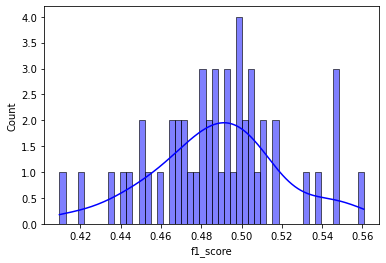

In [10]:
sns.histplot(df1['f1_score'], bins=50, label='Background',kde = True,color='b')

In [22]:
 ax = sns.kdeplot(df1['f1_score'], shade=True, color="r")

NameError: name 'sns' is not defined

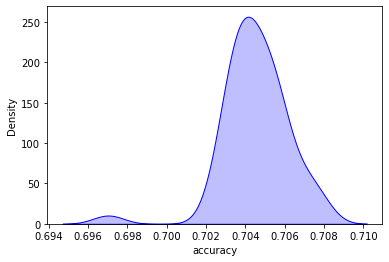

In [50]:
ax = sns.kdeplot(df1['accuracy'], shade=True, color="b")

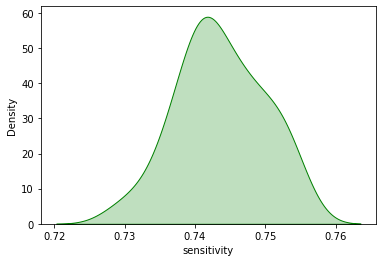

In [51]:
ax = sns.kdeplot(df1['sensitivity'], shade=True, color="g")

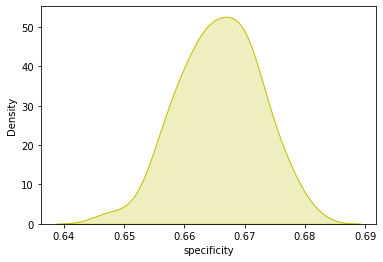

In [52]:
ax = sns.kdeplot(df1['specificity'], shade=True, color="y")

In [11]:
df1['f1_score'].std(ddof = 0)

0.0028074338350932647

In [29]:
df1.std(ddof=0)

f1_score       0.020833
accuracy       0.002338
sensitivity    0.040083
specificity    0.039792
dtype: float64

In [18]:
#df = pd.DataFrame.from_items(zip(a.index, a.str.split(' '))).T
df = pd.DataFrame([[s.index[i]] + s.str.split(' ')[i] for i in range(0, len(s))])

AttributeError: Can only use .str accessor with string values!

In [21]:
sqrt(0.001026)

NameError: name 'sqrt' is not defined

In [22]:
import math

In [23]:
math.sqrt(0.001026)

0.032031234756093936

In [24]:
df1.mean()

f1_score       0.488374
accuracy       0.499879
sensitivity    0.518772
specificity    0.480994
dtype: float64

In [26]:
s = df1['f1_score'].mean()

In [28]:
(df1['f1_score'] - s^2)^2

TypeError: Cannot perform 'xor' with a dtyped [float64] array and scalar of type [bool]

In [32]:
s**2

0.23850897548110261

In [33]:
s

0.4883738071202249

In [39]:
b = (df1['f1_score'] -s)**2

In [40]:
b.mean()

0.0010058088385954422

In [37]:
df1['f1_score'].head(3)

0    0.505981
1    0.538955
2    0.516435
Name: f1_score, dtype: float64

In [38]:
b.mean()

-9.547918011776346e-17